# Arbaro demo scene

Notebook: Hannah Weiser, 2026

This demo showcases two highly detailed tree models scanned from two terrestrial laser scanning (TLS) scanning positions.

## Imports

In [1]:
import helios
import numpy as np

## Creating the virtual scene

Our virtual scene consists of three scene parts - a ground plane and two trees - all loaded as 3D models in .OBJ format. The ground plane is additionally scaled by a factor of 100.

The tree models use the y-axis as "up" axis. Hence, we set `up_axis="y"` (default is "z"). We furthermore scale the tree models down to half their size and translate them to position them in the scene. Finally, we create a static scene from the loaded scene parts.

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj("../data/sceneparts/basic/groundplane/groundplane.obj").scale(100)  # scale groundplane by 100
tree1 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/black_tupelo_low.obj", up_axis="y")  # 3D models exported from Blender often have the Y-axis as "up-axis"
tree2 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/sassafras_low.obj", up_axis="y")
# Trees should both be scaled down by half and translated
tree1 = tree1.scale(0.5).translate([0.0, 15.0, 0.0])
tree2 = tree2.scale(0.5).translate([-10.0, 15.0, 0.0])
# create scene
scene = helios.StaticScene(scene_parts=[groundplane, tree1, tree2])

## Platform and scanner

HELIOS++ comes with a wide range of pre-defined scanners and platforms. We can check which scanners and platforms are available using `helios.list_scanners()` and `helios.list_platforms()`.

In [3]:
helios.list_scanners()

['leica_als50',
 'leica_als50_ii',
 'optech_2033',
 'optech_3100',
 'optech_galaxy',
 'riegl_lms_q560',
 'riegl_lms_q780',
 'riegl_vq_780i',
 'riegl_vux_1uav',
 'riegl_vux_1uav22',
 'riegl_vux_1ha22',
 'riegl_vq_880g',
 'riegl_vq_1560i',
 'livox_mid70',
 'livox_mid100',
 'livox_mid100a',
 'livox_mid100b',
 'livox_mid100c',
 'riegl_vz_400',
 'riegl_vz_1000',
 'riegl_vq_450',
 'livox_mid70_tls',
 'vlp16',
 'velodyne_hdl_64e',
 'tractor_scanner',
 'pano_scanner']

In [4]:
helios.list_platforms()

['sr22',
 'quadcopter',
 'copter_linearpath',
 'tractor',
 'tractor_leftside',
 'vehicle_linearpath',
 'vmx_450_car_left',
 'vmx_450_car_right',
 'vmq_1ha_car',
 'simple_linearpath',
 'tripod']

For this demo, we use the "RIEGL VZ-400" scanner mounted on a "tripod" platform.

In [5]:
scanner = helios.scanner_from_name("riegl_vz_400")
platform = helios.platform_from_name("tripod")

Predefined scanners and platforms are defined in the `platforms.xml`, `scanners_als.xml`, and `scanners_tls.xml` files in the [`python/helios/data`](https://github.com/3dgeo-heidelberg/helios/tree/main/python/helios/data) directory. You can also define your own scanners and platforms by creating your own XML files following the same format and making sure the file is in one of the helios search directories. By default, these are the current working directory and the `helios` and `helios/data` directories of the helios package.

You can add custom folders to the asset search path using `helios.add_asset_directory()`.

In [6]:
helios.add_asset_directory("<path_to_your_custom_assets>")

You can look at the XML definition of our chosen scanner here: https://github.com/3dgeo-heidelberg/helios/blob/main/python/helios/data/scanners_tls.xml

There are a lot of scanner-specific settings, including the accuracy (`accuracy_m`), the beam divergence (`beamDivergence_rad`), and a list of possible pulse frequencies (`pulseFreq_Hz`). The scanner uses a rotating prism as the beam deflector, most likely a triangular prism. The actual output window mentioned in the [data sheet](https://www.laser-3d.pl/wp-content/uploads/10_DataSheet_VZ-400_2014-09-19.pdf) (+60° to -40° = 100°; see the image below) is smaller than the maximum output window (2 x 120° = 240°) in order to prevent the beam from hitting another face of the rotating deflector, which would result in scattering in not-well defined directions. In HELIOS, we define the actual field of view using the `scanAngleEffectiveMax_deg` and the maximum field of view using the `scanAngle_deg`. Because the maximum field of view is not usually provided in the datasheet, we must look at the ratio of the effective measurement rate to the pulse repetition rate, which is the same as the ratio between `scanAngleEffectiveMax_deg` and `scanAngle_deg`. For the *RIEGL* VZ-400, this ratio is 2.4, as shown below in an excerpt from the data sheet. Therefore, we can compute the maximum field of view as 2.4 times the actual field of view, i.e., 100° x 2.4 = 240°. Because the scan angles in HELIOS are defined as half-angles, we divide by two to get the maximum `scanAngle_deg` of 120°.

[<img src="images/VZ400_technical_data.png" alt="excerpt from RIEGL VZ-400 data sheet" width="800"/>](images/VZ400_technical_data.png)
*Source: [RIEGL Laser Measurement Systems](http://riegl.com/) (2017): [RIEGL VZ-400 data sheet](https://www.laser-3d.pl/wp-content/uploads/10_DataSheet_VZ-400_2014-09-19.pdf)*

## Scanner settings

Below, we define two sets of scanner settings, which will be used for the two legs. In the first version (`scanner_settings1`), we define the scan frequency and the head rotation speed for the scanner. 

However, for TLS, users typically do not specify these settings, but instead provide a vertical and horizontal angular resolution. This is demonstrated in the `scanner_settings2`. HELIOS++ then internally computed the needed scan frequency and head rotation speed to achieve these resolutions.

Note that we can set units in two different ways, either expressed as strings like `"10 deg/s"` or by multiplying with units from the `helios.units` object. This is implemented with the Python package [`pint`](https://github.com/hgrecco/pint).
Note that these are the default units that HELIOS++ uses:
- Angle: rad 
- Frequency: Hz
- Length: m
- TimeInterval: s

So especially for angles, users are advised to take care of the radians to degree conversion where needed.

In [7]:
scanner_settings1 = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                           scan_frequency=120,  # Hz
                                           min_vertical_angle="-40 deg",
                                           max_vertical_angle="60 deg",
                                           head_rotation="10 deg/s"
                                          )
# for rotating head and rotating mirror terrestrial laser scanners, we can also provide 
# the vertical and horizontal angular resolution instead of scan frequency and head rotation speed
scanner_settings2 = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                           vertical_resolution=0.09 * helios.units.deg,
                                           horizontal_resolution=0.09 * helios.units.deg,
                                           min_vertical_angle=-40 * helios.units.deg,
                                           max_vertical_angle=60 * helios.units.deg
                                          )

# Full waveform settings
fullwave_settings = helios.FullWaveformSettings(
    bin_size=0.2 * helios.units.ns,
    beam_sample_quality=3  # default
)

## Scan positions

Next, we define two scan positions for our TLS survey. In HELIOS++, scan positions (or waypoints for mobile surveys) are called "legs". Below, we first create the survey with our defined scanner, platform, scene, and full waveform settings, and then add the two legs, specifying the platform positions and the horizontal field of view of the sensor.

In [8]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene, full_waveform_settings=fullwave_settings)
# first scan position
survey.add_leg(scanner_settings=scanner_settings1,
               x=1.0,
               y=25.5,
               z=1.5,
               force_on_ground=True,  # this works because of the specification in the groundplane.mtl file
               rotation_start_angle=100 * helios.units.deg,
               rotation_stop_angle=225 * helios.units.deg
              )
# second scan position, here we use the other scan setting definition
survey.add_leg(scanner_settings=scanner_settings2,
               x=-4.0,
               y=-2.5,
               z=1.5,
               force_on_ground=True,
               rotation_start_angle=-45 * helios.units.deg,
               rotation_stop_angle=45 * helios.units.deg
              )

## Executing the survey

Per defult, the `survey.run()` method returns two NumPy arrays, points measurements and the recorded trajectory.

In [9]:
points, trajectories = survey.run(verbosity=helios.LogVerbosity.VERBOSE, format=helios.OutputFormat.NPY)

`points` and `trajectories` are NumPy arrays of structured data type:

In [10]:
points[:3]

array([(0, 0, [-2.55024787e+00,  2.48692282e+01, -4.74013063e-04], [-0.89052385, -0.15821918, -0.42653717], [ 1.       , 25.5      , -5.2726975], 3.98669598, 29401522.27561153, 0., 1, 1, 225, 0, 513385.00745, 0),
       (0, 0, [-4.82338487e+00,  2.44650249e+01,  4.28282007e-04], [-0.94627872, -0.16817966, -0.27617418], [ 1.       , 25.5      , -5.2726975], 6.15398479,  7435872.48534716, 0., 1, 1, 257, 0, 513385.00777, 0),
       (0, 0, [-2.59235156e+00,  2.48617412e+01,  1.72470828e-03], [-0.89262327, -0.15859379, -0.42198544], [ 1.       , 25.5      , -5.2726975], 4.02448792, 22741182.92065482, 0., 1, 1, 226, 0, 513385.00746, 0)],
      dtype=[('channel_id', '<u8'), ('hit_object_id', '<i4'), ('position', '<f8', (3,)), ('beam_direction', '<f8', (3,)), ('beam_origin', '<f8', (3,)), ('distance', '<f8'), ('intensity', '<f8'), ('echo_width', '<f8'), ('return_number', '<i4'), ('number_of_returns', '<i4'), ('fullwave_index', '<i4'), ('classification', '<i4'), ('gps_time', '<f8'), ('point_sou

In [11]:
trajectories[:3]

array([(513385.  , [ 1. , 25.5,  0. ], -0., 0., -0.),
       (513385.01, [ 1. , 25.5,  0. ], -0., 0., -0.),
       (513385.02, [ 1. , 25.5,  0. ], -0., 0., -0.)],
      dtype=[('gps_time', '<f8'), ('position', '<f8', (3,)), ('roll', '<f8'), ('pitch', '<f8'), ('yaw', '<f8')])

If we want a different output format, we need to change the `format` parameter of the method. Available options are:
- NPY (default)
- LAS
- LAZ
- XYZ
- LASPY

Not that the LASPY format also returns two Python objects, but the first is a `laspy.LasData` instance instead of a NumPy array. 

If LAS, LAZ, or XYZ are provided as format, then the output is written to file and the `.run()` method returns only a single value, the path to the created output directory.

We can also set different log verbosity levels.

In [12]:
survey.run(verbosity=helios.LogVerbosity.QUIET, format=helios.OutputFormat.LAZ)

WindowsPath('d:/Software/_helios_versions/helios/example_notebooks/output/2026-02-13_23-36-39')

## Visualizing the result

Finally, let's visualize the simulated points using `matplotlib`.

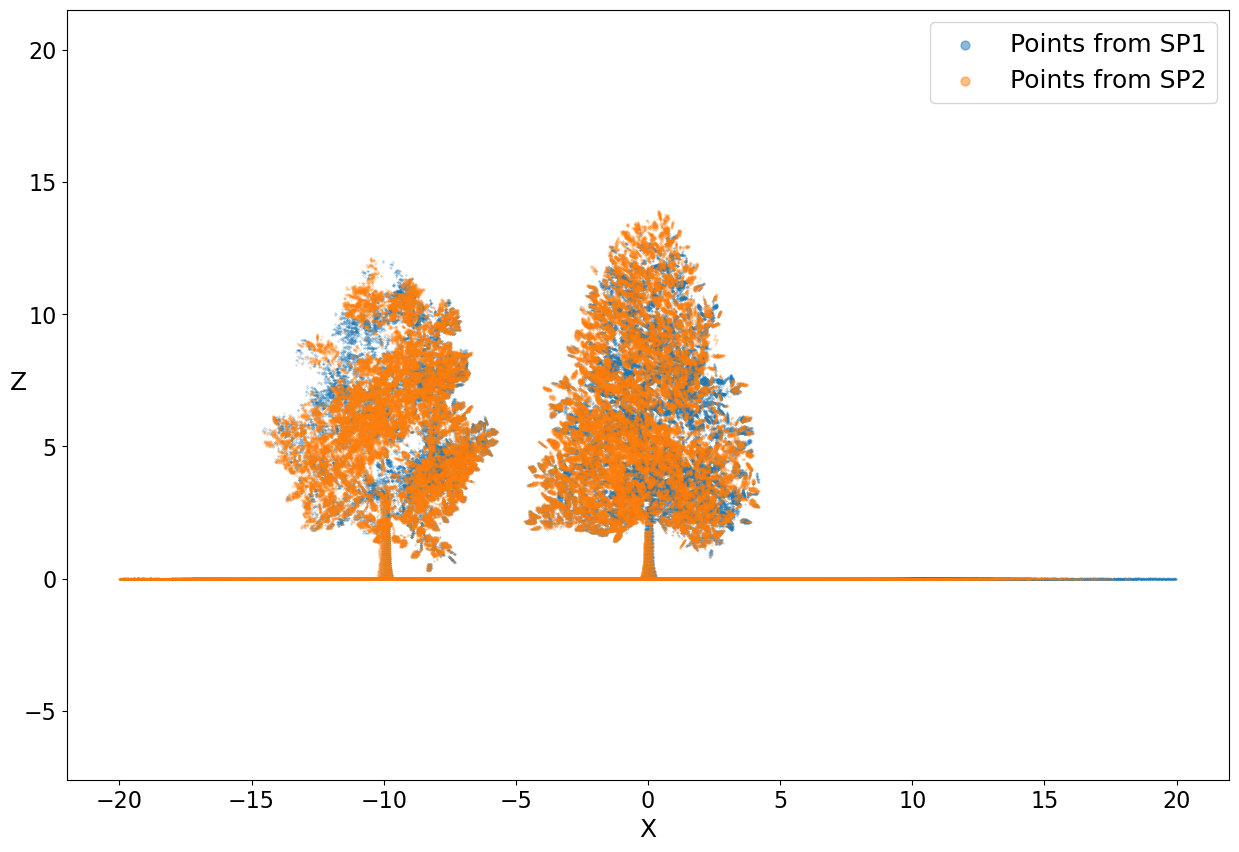

In [13]:
import matplotlib.pyplot as plt

pos = points["position"]

# discard points outside of [-20, -20] to [20, 20] (x, y)
points_sub = points[
    (pos[:, 0] > -20) & (pos[:, 1] > -20) & (pos[:, 0] < 20) & (pos[:, 1] < 20)
]
pos = points_sub["position"]

sp_1 = points_sub["point_source_id"] == 0
sp_2 = points_sub["point_source_id"] == 1
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(
   pos[sp_1, 0], pos[sp_1, 2], s=0.1, alpha=0.5, label="Points from SP1"
)
ax.scatter(
   pos[sp_2, 0], pos[sp_2, 2], s=0.1, alpha=0.5, label="Points from SP2"
)
plt.axis("equal")
ax.tick_params(labelsize=16)
plt.xlabel("X", fontsize=18)
plt.ylabel("Z", fontsize=18, rotation=0)
plt.legend(fontsize=18, markerscale=20)
plt.show()